Step 4: Model Diagnosis and Tuning
==================================

Dataset: Pima Indian diabetes
- 768 records
- 8 attributes
    1. Number of times pregnant
    2. Plasma glucose concentration at 2 hours in an oral glucose tolerance test
    3. Diastolic blood pressure (mmHg)
    4. Triceps skin fold thickness (mm)
    5. 2-Hous serum insulin ($\mu$U / ml)
    6. Body mass index (weight in kg/(height in m)^2)
    7. Diaetes pedigee function
    8. Age (years
- 2 classes
- 268 (34.9%) positive results for a diabetes test, and 500 (65.1%) negative results


Optimal Probability Cutoff Point
--------------------------------
> Predicted probability is a number between 0 and 1. Traditionally, $>0.5$ is the cutoff point used for converting predicted probability to 1 (positive), otherwise 0 (negative). This logic works well when your training data set has an equal examples of positive and negative cases; however, this is not the case in real-world scenarios.

> *Optical cutoff point*: the point where the true positive rate is high and the false positive rate is low. Anything above this threshold can be labeled as 1, else 0.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics

In [41]:
plt.style.use(['seaborn-darkgrid', 'seaborn-talk'])

In [42]:
# Load the data
df = pd.read_csv("../data/Diabetes.csv")
df

preg_count  glucose_concentration  blood_pressure  skin_thickness  \
0             6                    148              72              35   
1             1                     85              66              29   
2             8                    183              64               0   
3             1                     89              66              23   
4             0                    137              40              35   
..          ...                    ...             ...             ...   
763          10                    101              76              48   
764           2                    122              70              27   
765           5                    121              72              23   
766           1                    126              60               0   
767           1                     93              70              31   

     serum_insulin   bmi  pedigree_function  age  class  
0                0  33.6              0.627   50      1  
1                0  26.6              0.351   31      0  
2                0  23.3              0.672   32      1  
3               94  28.1              0.167   21      0  
4              168  43.1              2.288   33      1  
..             ...   ...                ...  ...    ...  
763            180  32.9              0.171   63      0  
764              0  36.8              0.340   27      0  
765            112  26.2              0.245   30      0  
766              0  30.1              0.349   47      1  
767              0  30.4              0.315   23      0  

[768 rows x 9 columns]

In [43]:
# Target variable % distribution
print(df['class'].value_counts(normalize=True))

0    0.651042
1    0.348958
Name: class, dtype: float64


In [44]:
X = df.iloc[:, :8]
y = df['class']

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate a logistic regression model, and fit
model = LogisticRegression(solver='liblinear')
model = model.fit(X_train, y_train)

# Predict class labels for the train set. The predict function converts probability values > .5 and 1 else 0
y_pred = model.predict(X_train)

# Generate class probabilities
probs = model.predict_proba(X_train)
y_pred_prob = probs[:, 1]

# Generate evaluation metrics
print("Accuracy:", metrics.accuracy_score(y_train, y_pred, ))

Accuracy: 0.7672253258845437


> The optimal cut-off would be where the true positive rate (tpr) is high and the false positive rate (fpr) is low, and tpr-(1-fpr) is zero or near to zero.

In [45]:
# Extract false positive, true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
print(f"Area under the ROC curve: {roc_auc}")

# i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr': pd.Series(fpr), 'tpr': pd.Series(tpr), '1-fpr': pd.Series(1-fpr), 'tf': pd.Series(tpr-(1-fpr)), 'thresholds': pd.Series(thresholds)})
roc.iloc[(roc.tf).abs().argsort()[:1]]

Area under the ROC curve: 0.83324817408554


fpr       tpr     1-fpr        tf  thresholds
107  0.241983  0.757732  0.758017 -0.000286    0.361066

Text(0.5, 1.0, 'Receiver operating characteristic')

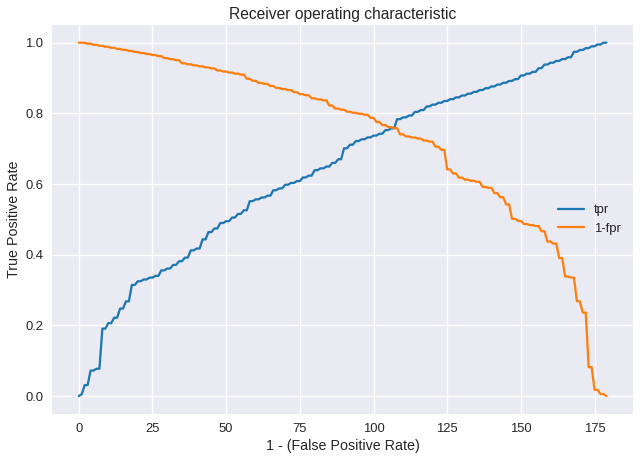

In [46]:
# Plot tpr vs 1-fpr
fig, ax = plt.subplots()

plt.plot(roc['tpr'], label='tpr')
plt.plot(roc['1-fpr'], label='1-fpr')
plt.legend()
plt.xlabel("1 - (False Positive Rate)")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")

> From the chart, the point where tpr crosses 1-fpr is the optimal cutoff point.

In [47]:
def Find_Optimal_Cutoff(target, predicted):
    """Find the optimal probability cutoff point for a classification model related to the event rate.
    
    Parameters
    ----------
    target
        Matrix with dependent or target data, where rows are observations.
    predicted
        Matrix with predicted data, where rows are observations.
        
    Returns
    -------
    list
        The optimal cutoff value.
    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    roc = pd.DataFrame({
        'tf': tpr-(1-fpr),
        'threshold': threshold,
    })
    roc_t = roc.iloc[roc.tf.abs().argsort()[:1]]
    
    return list(roc_t['threshold'])

# Find optimal probability threshold
# Note: probs[:, 1] will have the probability of being a positive label
threshold = Find_Optimal_Cutoff(y_train, probs[:, 1])
print("Optimal Probability Threshold:", threshold)

# Applying the threshold to the predictation probability
y_pred_optimal = np.where(y_pred_prob >= threshold, 1, 0)

# Let's compare the accuracy of traditional/normal approach vs optimal cutoff
print("\nNormal - Accuracy:", metrics.accuracy_score(y_train, y_pred))
print("Optimal Cutoff - Accuracy:", metrics.accuracy_score(y_train, y_pred_optimal))

print("\nNormal - Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_pred))
print("Optimal - Cutoff Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_pred_optimal))

Optimal Probability Threshold: [0.3610661913804565]

Normal - Accuracy: 0.7672253258845437
Optimal Cutoff - Accuracy: 0.7579143389199255

Normal - Confusion Matrix:
 [[303  40]
 [ 85 109]]
Optimal - Cutoff Confusion Matrix:
 [[260  83]
 [ 47 147]]


> - *Random undersampling*: Reduce majority class to match minority class count
> - *Random oversampling*: Increase minority class by randomly picking samples within minority class till counts of both class match
> - *Synthetic Minority Over-Sampling Technique (SMOTE)*: Increase minority class by introducing synthetic examples through connecting all $k$ (default to 5) minority class nearest neighbors, using feature space similarity (Euclidean distance)

In [48]:
# Load libraries
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Generate the dataset with 2 features to keep it simple
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, weights=[0.9, 0.1], random_state=2017)

print("Positive class:", y.tolist().count(1))
print("Negative class:", y.tolist().count(0))

Positive class: 514
Negative class: 4486


Text(0.5, 1.0, 'SMOTE: 1=4486, 0=4486')

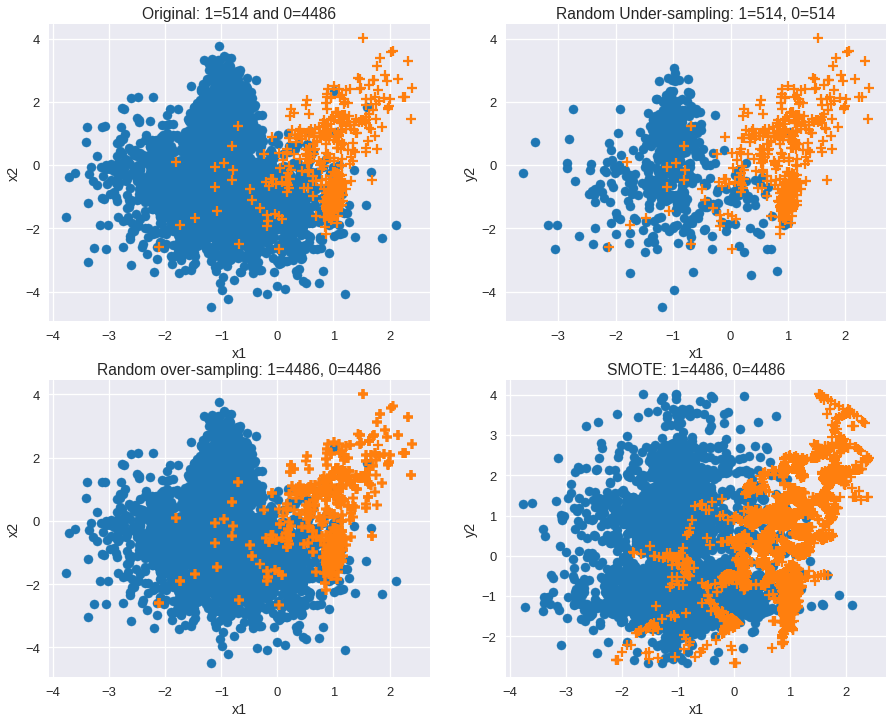

In [49]:
# Apply the random under-sampling
rus = RandomUnderSampler()
X_RUS, y_RUS = rus.fit_sample(X, y)

# Apply the random over-sampling
ros = RandomOverSampler()
X_ROS, y_ROS = ros.fit_sample(X, y)

# Apply regular SMOTE
sm = SMOTE()
X_SMOTE, y_SMOTE = sm.fit_sample(X, y)

# Original vs resamples subplots
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 12))

ax1.scatter(X[y==0, 0], X[y==0, 1], marker="o")
ax1.scatter(X[y==1, 0], X[y==1, 1], marker="+")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_title(f"Original: 1={y.tolist().count(1)} and 0={y.tolist().count(0)}")

ax2.scatter(X_RUS[y_RUS==0, 0], X_RUS[y_RUS==0, 1], marker="o")
ax2.scatter(X_RUS[y_RUS==1, 0], X_RUS[y_RUS==1, 1], marker="+")
ax2.set_xlabel("x1")
ax2.set_ylabel("y2")
ax2.set_title(f"Random Under-sampling: 1={y_RUS.tolist().count(1)}, 0={y_RUS.tolist().count(0)}")

ax3.scatter(X_ROS[y_ROS==0, 0], X_ROS[y_ROS==0, 1], marker="o")
ax3.scatter(X_ROS[y_ROS==1, 0], X_ROS[y_ROS==1, 1], marker="+")
ax3.set_xlabel("x1")
ax3.set_ylabel("x2")
ax3.set_title(f"Random over-sampling: 1={y_ROS.tolist().count(1)}, 0={y_ROS.tolist().count(0)}")

ax4.scatter(X_SMOTE[y_SMOTE==0, 0], X_SMOTE[y_SMOTE==1, 1], marker="o")
ax4.scatter(X_SMOTE[y_SMOTE==1, 0], X_SMOTE[y_SMOTE==1, 1], marker="+")
ax4.set_xlabel("x1")
ax4.set_ylabel("y2")
ax4.set_title(f"SMOTE: 1={y_SMOTE.tolist().count(1)}, 0={y_SMOTE.tolist().count(0)}")

**Caution**: Keep in mind that random undersampling raises the opportunity for loss of information or concepts, s we are reducing the majority class, and that random oversampling & SMOTE can lead to an overfitting issue due to multiple related instances.

In [50]:
from sklearn import tree

X_RUS_train, X_RUS_test, y_RUS_train, y_RUS_test = train_test_split(X_RUS, y_RUS, test_size=0.3, random_state=2020)
X_ROS_train, X_ROS_test, y_ROS_train, y_ROS_test = train_test_split(X_ROS, y_ROS, test_size=0.3, random_state=2020)

X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.3, random_state=2020)

# Build a decision tree classifier
clf = tree.DecisionTreeClassifier(random_state=2020)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_rus = clf.fit(X_ROS_train, y_ROS_train)
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)

# Evaluate model performance
print("\nRUS - Train AUC:", metrics.roc_auc_score(y_RUS_train, clf.predict(X_RUS_train)))
print("RUS - Test AUC:", metrics.roc_auc_score(y_RUS_test, clf.predict(X_RUS_test)))
print("\nROS - Train AUC:", metrics.roc_auc_score(y_ROS_train, clf.predict(X_ROS_train)))
print("ROS - Test AUC:", metrics.roc_auc_score(y_ROS_test, clf.predict(X_ROS_test)))
print("\nSMOTE - Train AUC:", metrics.roc_auc_score(y_SMOTE_train, clf.predict(X_SMOTE_train)))
print("SMOTE - Test AUC:", metrics.roc_auc_score(y_SMOTE_test, clf.predict(X_SMOTE_test)))


RUS - Train AUC: 0.9902890450829822
RUS - Test AUC: 0.9870244394053918

ROS - Train AUC: 0.9947233770386952
ROS - Test AUC: 0.9626341463953186

SMOTE - Train AUC: 1.0
SMOTE - Test AUC: 0.9493891132827357


Bias and Variance
-----------------
> A fundamental problem with supervised learning is the bias-variance tradeoff. Ideally, a model should have two key characteristics:
> 1. It should be sensitive enough to accurately capture the key patterns in the training dataset.
> 2. It should be generalized enough to work well on any unseen datasets.


### Bias
> Two key reasons for bias are
> 1) not including the right features and
> 2) not picking the correct order of polynomial degree for model fitting.
>
> To solve the underfitting issue or to reduce bias, try including more meaningful features and try to increase the model complexity by trying higher order polynomial fittings.


### Variance
> The key reason for overfitting is using  a highe order polynomial degree (may not be required), which will fit the decision boundary tool well to all data points including the noise of the train dataset instead of the underlying relationship.
>
> To solve the overfitting issue:
> - Try to reduce the number of features, that is, keep only the meaningful features or try regularization methods that will keep all the features but reduce the magnitude of the feature parameter.
> - Dimension reduction can eliminate noisy features, in turn reducing the model variance.
> - Bringing more data points to make training dataset large will also reduce varaince.
> - Chossing the right model parameters can help to reduce the bias and variance, for example,
>   - Using right regularization parameters can decrease variance in regression-based models.
>   - For a decision tree, reducing the depth of the decision tree will reduce the variance.



K-Fold Cross Validation
-----------------------
> K-fold cross-validation splits the training dataset into $k$ folds without replacement--any given data point will only be part of one of the subsets, where ($k-1$) folds are used for the model training and one fold is used for testing. The procedure is repeated $k$ times so that we obtain $k$ models and performance estimates.

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv("../data/Diabetes.csv")

X = df.iloc[:, :8].values
y = df['class'].values

# Normalize Data
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

# Build a decision tree classifier
clf = tree.DecisionTreeClassifier(random_state=2020)

# Evaluate the model using 10-fold cross-validation
train_scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5)
test_scores = cross_val_score(clf, X_test, y_test, scoring="accuracy", cv=5)
print("Train Fold AUC Scores:", train_scores)
print("Train  CV  AUC Score ", train_scores.mean())

print("\nTest Fold AUC Scores:", test_scores)
print("Test  CV  AUC Score :", test_scores.mean())

Train Fold AUC Scores: [0.69444444 0.71296296 0.68224299 0.74766355 0.68224299]
Train  CV  AUC Score  0.7039113880235375

Test Fold AUC Scores: [0.70212766 0.67391304 0.65217391 0.76086957 0.65217391]
Test  CV  AUC Score : 0.6882516188714154


### Stratified K-fold Cross-Validation
> The class proportions are preserved in each fold, leading to better bias and variance estimates.

In [52]:
from sklearn import model_selection

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

train_scores = []
test_scores = []
k = 0

for (train, test) in kfold.split(X_train, y_train):
    clf.fit(X_train[train], y_train[train])
    train_score = clf.score(X_train[train], y_train[train])
    train_scores.append(train_score)
    
    # Score for test set
    test_score = clf.score(X_train[test], y_train[test])
    test_scores.append(test_score)
    
    k += 1
    print(f"Fold: {k}, Class dist.: {np.bincount(y_train[train])}, Train Acc.: {train_score:.3f}, Test Acc.: {test_score:.3f}")
    
print(f"\nTrain CV accuracy: {np.mean(train_scores):.3f}")
print(f"Test CV accuracy: {np.mean(test_scores):.3f}")

Fold: 1, Class dist.: [281 148], Train Acc.: 1.000, Test Acc.: 0.667
Fold: 2, Class dist.: [281 148], Train Acc.: 1.000, Test Acc.: 0.593
Fold: 3, Class dist.: [282 148], Train Acc.: 1.000, Test Acc.: 0.682
Fold: 4, Class dist.: [282 148], Train Acc.: 1.000, Test Acc.: 0.701
Fold: 5, Class dist.: [282 148], Train Acc.: 1.000, Test Acc.: 0.729

Train CV accuracy: 1.000
Test CV accuracy: 0.674


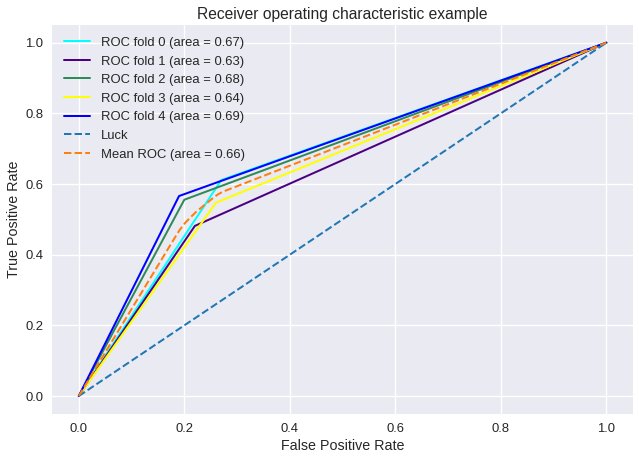

In [53]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from numpy import interp

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

mean_tpr = 0.
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, y), colors):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label=f"ROC fold {i} (area = {roc_auc:.2f})")
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, label="Luck")

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, linestyle="--", label=f"Mean ROC (area = {mean_auc:.2f})", lw=lw)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend()

Ensemble Methods
----------------
> Ensemble methods enable combining multiple model scores into a single score to create a robust generalized model.
>
> At a high level, there are two types of ensemble methods:
> 1. Combine multiple models of similar type.
>   - Bagging (boostrap aggregation)
>   - Boosting
> 2. Combine multiple models of various types.
>   - Vote classification
>   - Blending or stacking


### Bagging


In [54]:
# Bagged Decision Trees for Classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X = df.iloc[:, :8].values
y = df['class'].values

# Normalize
X = StandardScaler().fit_transform(X)

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2020)

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
num_trees = 100

# Decision Tree with 5 fold cross validation
clf_DT = DecisionTreeClassifier(random_state=2020).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT, X_train, y_train, cv=kfold)
print("Decision Tree (stand alone) - Train:", results.mean())
print("Decision Tree (stand alone) - Test :", metrics.accuracy_score(clf_DT.predict(X_test), y_test))

# Using Bagging; buid 100 decision tree models and average/majority vote prediction
clf_DT_Bag = BaggingClassifier(base_estimator=clf_DT, n_estimators=num_trees, random_state=2020).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT_Bag, X_train, y_train, cv=kfold)
print("\nDecision Tree (Bagging) - Train:", results.mean())
print("Decision Tree (Bagging) - Test :", metrics.accuracy_score(clf_DT_Bag.predict(X_test), y_test))

Decision Tree (stand alone) - Train: 0.7003998400639744
Decision Tree (stand alone) - Test : 0.7597402597402597

Decision Tree (Bagging) - Train: 0.75083300013328
Decision Tree (Bagging) - Test : 0.7857142857142857


### Feature Importance

Text(0.5, 1.0, 'Varaible Importance')

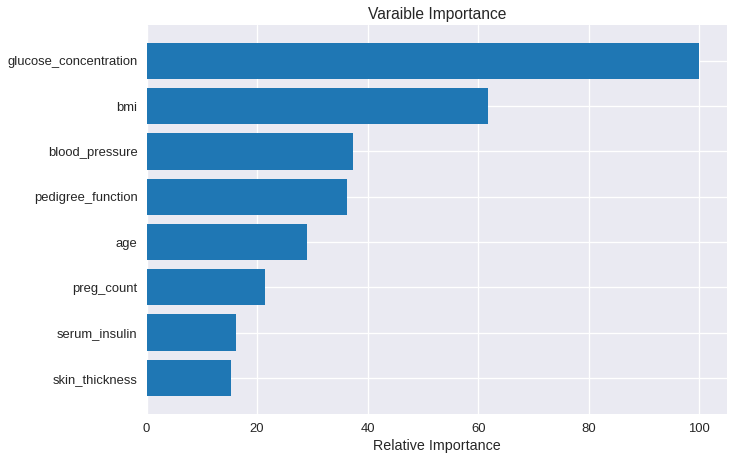

In [55]:
feature_importance = clf_DT.feature_importances_

# Make importances relative to max importance
feature_importance *= 100.0 / feature_importance.max()
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Varaible Importance")

### RandomForest

In [56]:
from sklearn.ensemble import RandomForestClassifier

num_trees = 100

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

clf_RF = RandomForestClassifier(n_estimators=num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_RF, X_train, y_train, cv=kfold)

print("Random Forest (Bagging) - Train:", results.mean())
print("Random Forest (Bagging) - Test :", metrics.accuracy_score(clf_RF.predict(X_test), y_test))

Random Forest (Bagging) - Train: 0.7540717046514728
Random Forest (Bagging) - Test : 0.7922077922077922


### Extremely Randomized Trees (ExtraTree)

In [57]:
from sklearn.ensemble import ExtraTreesClassifier

num_trees = 100

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

clf_ET = ExtraTreesClassifier(n_estimators=num_trees).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_ET, X_train, y_train, cv=kfold)

print("ExtraTree - Train:", results.mean())
print("ExtraTree - Test :", metrics.accuracy_score(clf_ET.predict(X_test), y_test))

ExtraTree - Train: 0.7491803278688525
ExtraTree - Test : 0.7857142857142857


### How Does the Decision Boundary Look?
> Let's perform PCA and consider only the first two principal components for easy plotting.
>
> Once we have run the model successfully, we can use the following code to draw decision boundaries for standalone vs. different bagging models.

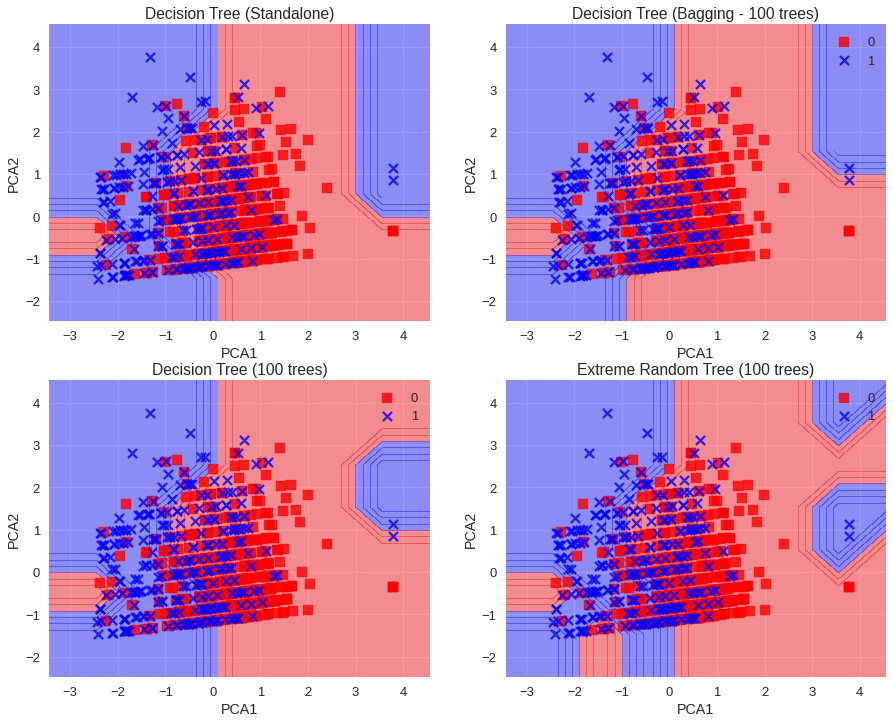

In [58]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# PCA
X = df.iloc[:, :2].values
X = PCA(n_components=2).fit_transform(X)

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

clf_DT = DecisionTreeClassifier(random_state=2020).fit(X_train, y_train)
clf_DT_Bag = BaggingClassifier(base_estimator=clf_DT, n_estimators=num_trees, random_state=2020).fit(X_train, y_train)
clf_RF = RandomForestClassifier(n_estimators=num_trees).fit(X_train, y_train)
clf_ET = ExtraTreesClassifier(n_estimators=num_trees).fit(X_train, y_train)

def plot_decision_regions(X, y, classifier, ax):
#     h = .05    # Step size in the mesh
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('r', 'b', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max), np.arange(x2_min, x2_max))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl)
        
# Plot the decision boundary
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 12))

plot_decision_regions(X, y, clf_DT, ax1)
ax1.set_title("Decision Tree (Standalone)")
ax1.set_xlabel("PCA1")
ax1.set_ylabel("PCA2")

plot_decision_regions(X, y, clf_DT_Bag, ax2)
ax2.set_title("Decision Tree (Bagging - 100 trees)")
ax2.set_xlabel("PCA1")
ax2.set_ylabel("PCA2")
ax2.legend()

plot_decision_regions(X, y, clf_RF, ax3)
ax3.set_title("Decision Tree (100 trees)")
ax3.set_xlabel("PCA1")
ax3.set_ylabel("PCA2")
ax3.legend()

plot_decision_regions(X, y, clf_ET, ax4)
ax4.set_title("Extreme Random Tree (100 trees)")
ax4.set_xlabel("PCA1")
ax4.set_ylabel("PCA2")
ax4.legend()

### Bagging--Essential Tuning Parameters
> - *n_estimators*: This is the number of trees--the larger the better. Note that beyond a certain point, the results will not improve significantly.
> - *max_features*: This is the random subset of features to be used for splitting a node--the lower the better to reduce variance (but increases bias). Ideally, for a regression problem it should be equal to n_features (total number of features) and for classification, square root of n_features.
> - *n_jobs*: Number of cores to be used for parallel construction of trees. If set to -1, all available cores in the system are used, or you can specify the number.


Boosting
--------
> The core concept of boosting is that rather than an independent individual hypothesis, combining hypotheses in a sequential order increases the accuracy. Essentially, boosing algorithms convert the weak learners into strong learners. Boosting algorithms are well designed to address bias problems.
>
> At a high level the AdaBoosting process can be divided into three steps:
> - Assign uniform weights for all data points $W_o(x) = 1 / N$, where $N$ is the total number of training data points.
> - At each iteration, fit a classifier $y_m(x_n)$ to the training data and update weights to minimize the weighted error function.
> > The weight is calculated as
$$
W_n^{(m+1)} = W_n^{(m)} \exp \left\{\propto_m y_m (x_n) \ne t_n \right\}.
$$
> > The hypothesis weight or the loss function is given by
$$
\propto_m = \frac{1}{2} \log\left\{\frac{1 - \epsilon_m}{\epsilon_m}\right\},
$$
and the term rate is given by
$$
\epsilon_m = \frac{\sum_{n=1}^N W_n^{(m)} \text{I} (y_m (x_n) \ne t_n)}{\sum_{n=1}^N W_n^{(m)}},
$$
> > where $(y_m(x_n) \ne t_n)$ has values 0 if $x_n$ correctly classified else 1.
> - The final model is given by
$$
Y_m = \text{sign}\left(\sum_{m=1}^M \propto_m y_m (x) \right)
$$

In [59]:
# Bagged Decision Trees for Classification
from sklearn.ensemble import AdaBoostClassifier

X = df[['age', 'serum_insulin']]
y = df['class'].values

# Normalize
X = StandardScaler().fit_transform(X)

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
num_trees = 100

# Decision Tree with 5 fold cross validation
# Let's restrict max_depth to 1 to have more impure leaves
clf_DT = DecisionTreeClassifier(max_depth=1, random_state=2020).fit(X_train, y_train)
results =model_selection.cross_val_score(clf_DT, X_train, y_train, cv=kfold.split(X_train, y_train))
print(f"Decision Tree (standalone) - CV Train: {results.mean():.2f}")
print(f"Decision Tree (standalone) - Train: {metrics.accuracy_score(clf_DT.predict(X_train), y_train)}")
print(f"Decision Tree (standalone) - Test : {metrics.accuracy_score(clf_DT.predict(X_test), y_test)}")

# Using Adaptive Boosting of 100 iterations
clf_DT_Boost = AdaBoostClassifier(base_estimator=clf_DT, n_estimators=num_trees, learning_rate=0.1, random_state=2020).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_DT_Boost, X_train, y_train, cv=kfold.split(X_train, y_train))
print(f"\nDecision Tree (AdaBoosting) - CV Train: {results.mean():.2f}")
print(f"Decision Tree (AdaBoosting) - Train: {metrics.accuracy_score(clf_DT_Boost.predict(X_train), y_train):.2f}")
print(f"Decision Tree (AdaBoosting) - Test : {metrics.accuracy_score(clf_DT_Boost.predict(X_test), y_test):.2f}")

Decision Tree (standalone) - CV Train: 0.64
Decision Tree (standalone) - Train: 0.6644951140065146
Decision Tree (standalone) - Test : 0.6298701298701299

Decision Tree (AdaBoosting) - CV Train: 0.70
Decision Tree (AdaBoosting) - Train: 0.74
Decision Tree (AdaBoosting) - Test : 0.66


### Gradient Boosting
> Due to the stagewise additivity, the loss function can be represented in a form suitable for optimization. This gave birth to a class of generalized boosting algorithms known as *generalized boosting machine* (GBM).
> *Gradient boosting* is an example implementation of GBM and it can work with different loss functions such as regression, clasification, risk modeling, etc.
>
> - Iteraively fit a classifier $y_m(x_n)$ to the training data.
> - Calculate the loss (i.e., the predicted value vs. actual value) for each model fit iteration $g_m(x)$ or compute the negative gradient and use it to fit a new base learner function $h_m(x)$, and find the best gradient descent step-size
$$
\delta_m = \text{argmin} \delta \sum_{i=1}^n L(y_m, y_{m-1}(x) + \delta h_m(x)).
$$
> - Update the function estimate $y_m(x) = y_{m-1}(x) + \delta h_m(x)$ and output $y_m(x)$.

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

# Using Gradient Boosting of 100 iterations
clf_GBT = GradientBoostingClassifier(n_estimators=num_trees, learning_rate=0.1, random_state=2020).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_GBT, X_train, y_train, cv=kfold)

print(f"Gradient Boosting - CV Train: {results.mean():.2f}")
print(f"Gradient Boosting - Train: {metrics.accuracy_score(clf_GBT.predict(X_train), y_train):.2f}")
print(f"Gradient Boosting - Test : {metrics.accuracy_score(clf_GBT.predict(X_test), y_test):.2f}")

Gradient Boosting - CV Train: 0.67
Gradient Boosting - Train: 0.80
Gradient Boosting - Test : 0.65


In [61]:
df = pd.read_csv("../data/digit.csv")
df

lettr  x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  \
0         T      2      8      3     5      1      8     13      0      6   
1         I      5     12      3     7      2     10      5      5      4   
2         D      4     11      6     8      6     10      6      2      6   
3         N      7     11      6     6      3      5      9      4      6   
4         G      2      1      3     1      1      8      6      6      6   
...     ...    ...    ...    ...   ...    ...    ...    ...    ...    ...   
19995     D      2      2      3     3      2      7      7      7      6   
19996     C      7     10      8     8      4      4      8      6      9   
19997     T      6      9      6     7      5      6     11      3      7   
19998     S      2      3      4     2      1      8      7      2      6   
19999     A      4      9      6     6      2      9      5      3      1   

       xybar  x2ybar  xy2bar  x-edge  xegvy  y-edge  yegvx  
0          6      10       8       0      8       0      8  
1         13       3       9       2      8       4     10  
2         10       3       7       3      7       3      9  
3          4       4      10       6     10       2      8  
4          6       5       9       1      7       5     10  
...      ...     ...     ...     ...    ...     ...    ...  
19995      6       6       4       2      8       3      7  
19996     12       9      13       2      9       3      7  
19997     11       9       5       2     12       2      4  
19998     10       6       8       1      9       5      8  
19999      8       1       8       2      7       2      8  

[20000 rows x 17 columns]

Gradient Boosting - Train: 0.75
Gradient Boosting - Test : 0.74
Predicted letter: ['T']


[[<matplotlib.axis.XTick at 0x7fabcc1b13d0>,
 Text(0.5, 0, 'Label'),
 Text(0, 0.5, 'Prediction Probability'),
 Text(0.5, 1.0, 'Round Ten'),
 None]

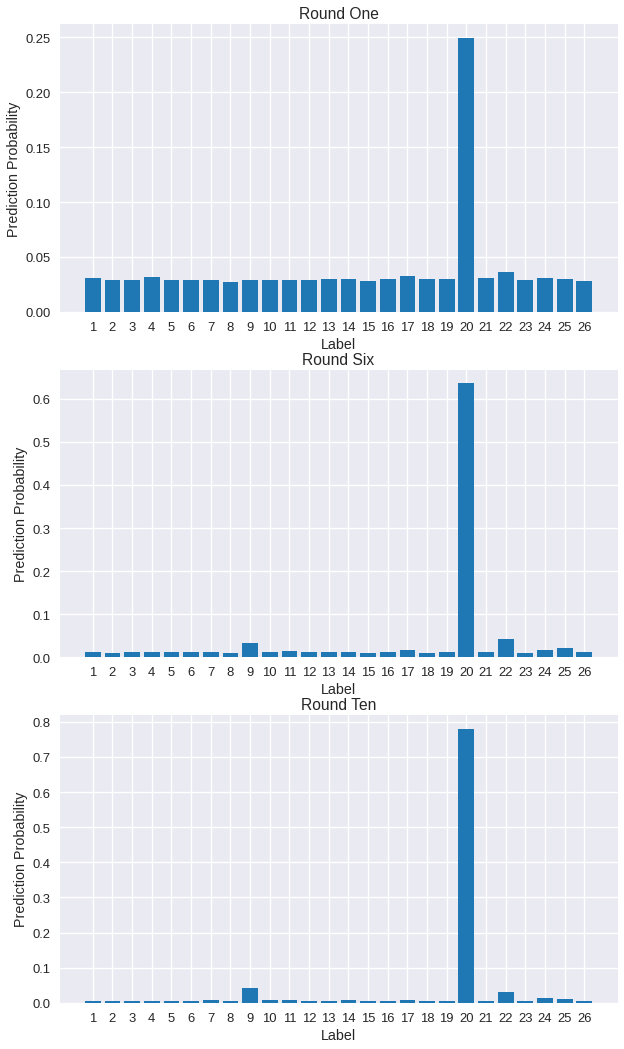

In [62]:
X = df.iloc[:, 1:17].values
y = df['lettr'].values

# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
num_trees = 10

clf_GBT = GradientBoostingClassifier(n_estimators=num_trees, learning_rate=0.1, random_state=2020).fit(X_train, y_train)
results = model_selection.cross_val_score(clf_GBT, X_train, y_train, cv=kfold)

print(f"Gradient Boosting - Train: {metrics.accuracy_score(clf_GBT.predict(X_train), y_train):.2f}")
print(f"Gradient Boosting - Test : {metrics.accuracy_score(clf_GBT.predict(X_test), y_test):.2f}")

# Predict for the letter 'T' and understand how the rediction accuracy changes in each boosting iteration
X_valid = (2, 8, 3, 5, 1, 8, 13, 0, 6, 6, 10, 8, 0, 8, 0, 8)
print("Predicted letter:", clf_GBT.predict([X_valid]))

# Staged prediction will give the predicted probability for each boosting iteration
stage_preds = list(clf_GBT.staged_predict_proba([X_valid]))
final_preds = clf_GBT.predict_proba([X_valid])

# Plot
x = range(1, 27)
label = np.unique(df['lettr'])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.bar(x, stage_preds[0][0], align="center")
ax1.set(xticks=x, xlabel="Label", ylabel="Prediction Probability", title="Round One", label=label)

ax2.bar(x, stage_preds[5][0], align="center")
ax2.set(xticks=x, xlabel="Label", ylabel="Prediction Probability", title="Round Six", label=label)

ax3.bar(x, stage_preds[9][0], align="center")
ax3.set(xticks=x, xlabel="Label", ylabel="Prediction Probability", title="Round Ten", label=label)

### Boosting--Essential Tuning Parameters
> Model complexity and overfitting can be controlled by using correct values for two categories of parameters:
>
> 1. Tree structure
>    *n_estimators*: This is the number of weak learners to be built.
>
>    *max_depth*: This is the maximum depth of the individual estimators. The best value depends on the interaction of the input variables.
>
>    *min_samples_leaf*: This will be helpful to ensure a sufficient number of samples results in leaf.
>
>    *subsample*: This is the fraction of the sample to be used for fitting individual models (default to 1). Typically, 0.8 (80%) is used to introduce a random selection of samples, which in turn increases the robustness against overfitting.
> 2. Regularization parameter
>
>    *learning_rate*: This controls the magnitude of change in estimators. The lower learning rate is better, which requires higher n_estimator (that is the trade-off).


### Xgboost (eXtreme Gradient Boosting)
Following [XGBoost Tutorials - Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html):
> XGBoost objective function: Training loss + regularization. See [XGBoost Tutorials - Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html).
\begin{equation}
\text{obj}(\theta) = L(\theta) + \Omega(\theta)
\end{equation}
> where $L$ is the training loss function, and $\Omega$ is the regularization term. The training loss measures how *predictive* our model is with respect to the training data. A common choice of $L$ is the *mean squared error*, which is given by
\begin{equation}
L(\theta) = \sum_{i} (y_i - \hat{y}_i).
\end{equation}
> Another commonly used loss function is logistic loss, to be used for logistic regression:
\begin{equation}
L(\theta) = \sum_i \left[ y_i \ln \left( 1 + \mathrm{e}^{-\hat{y}_i} \right) + \left(1 - y_i \right) \ln \left( 1 + \mathrm{e}^{\hat{y}_i} \right) \right].
\end{equation}

> Let us first refine the definition of the tree $f(x)$ as
\begin{equation}
f_t(x) = w_{q(x)}, \quad w \in \mathbb{R}^T, \qquad q: \mathbb{R}^d \to \left\{1, 2, \cdots, T \right\}.
\end{equation}
> Here $w$ is the vector of scores on leaves, $q$ is a function assigning each data point to the corresponding leaf, and $T$ is the number of leaves. In XGBoost, we define the complexity as
\begin{equation}
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2.
\end{equation}

> Some of the key advantaes of the xgboost algorithm are
> - It implements parallel processing.
> - It has a built-in standard to handle missing values, which means the user can specify a particular value different than other observations (such as -1 or -999) and pass it as a parameter.
> - It will split the tree up to maximum depth, unlike gradient boosting where it stops splitting the node on encountering a negative loss in the split.

In [63]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

df = pd.read_csv("../data/Diabetes.csv")
df

preg_count  glucose_concentration  blood_pressure  skin_thickness  \
0             6                    148              72              35   
1             1                     85              66              29   
2             8                    183              64               0   
3             1                     89              66              23   
4             0                    137              40              35   
..          ...                    ...             ...             ...   
763          10                    101              76              48   
764           2                    122              70              27   
765           5                    121              72              23   
766           1                    126              60               0   
767           1                     93              70              31   

     serum_insulin   bmi  pedigree_function  age  class  
0                0  33.6              0.627   50      1  
1                0  26.6              0.351   31      0  
2                0  23.3              0.672   32      1  
3               94  28.1              0.167   21      0  
4              168  43.1              2.288   33      1  
..             ...   ...                ...  ...    ...  
763            180  32.9              0.171   63      0  
764              0  36.8              0.340   27      0  
765            112  26.2              0.245   30      0  
766              0  30.1              0.349   47      1  
767              0  30.4              0.315   23      0  

[768 rows x 9 columns]

In [64]:
predictors = ['age', 'serum_insulin']
target = 'class'

# Most common preprocessing step include label encoding and missing value treatment
from sklearn import preprocessing

for f in df.columns:
    if df[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list[df[f]].values)

df.fillna((-999), inplace=True)

X = df[predictors]
X = StandardScaler().fit_transform(X)
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=2020)
num_rounds = 100

kfold =model_selection.StratifiedKFold(n_splits=5, random_state=2020)
clf_XGB = XGBClassifier(n_estimators=num_rounds, objective='binary:logistic', seed=2020)

# Use early_stopping_rounds to stop the cv when there is no score improvement
clf_XGB.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=False)

results = model_selection.cross_val_score(clf_XGB, X_train, y_train, cv=kfold)

print(f"\nXGBoost - CV Train: {results.mean():.2f}")
print(f"XGBoost - Train: {metrics.accuracy_score(clf_XGB.predict(X_train), y_train):.2f}")
print(f"XGBoost - Test : {metrics.accuracy_score(clf_XGB.predict(X_test), y_test):.2f}")


XGBoost - CV Train: 0.74
XGBoost - Train: 0.86
XGBoost - Test : 0.63


> Now let's also look at how to build a model using xgboost native interface, DMatrix, the internal data structure of xgboost for inpt data. It is good practice to convert the large dataset to DMatrix object to save preproccesing time.

In [65]:
xgtrain = xgb.DMatrix(X_train, label=y_train, missing=-999)
xgtest = xgb.DMatrix(X_test, label=y_test, missing=-999)

# Set xgboost params
param = {'max_depth': 3, # the maximum dpeth of each tree
         'objective': 'binary:logistic'}

clf_xgb_cv = xgb.cv(param, xgtrain, num_rounds, stratified=True,
                    nfold=5, early_stopping_rounds=20, seed=2020)

print(f"Optimal number of trees/estimators is {clf_xgb_cv.shape[0]}")

watchlist = [(xgtest, 'test'), (xgtrain, 'train')]
clf_xgb = xgb.train(param, xgtrain, clf_xgb_cv.shape[0], watchlist)

y_train_pred = (clf_xgb.predict(xgtrain, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)
y_test_pred = (clf_xgb.predict(xgtest, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)

print(f"XGB - Train: {metrics.accuracy_score(y_train_pred, y_train):.2f}")
print(f"XGB - Test : {metrics.accuracy_score(y_test_pred, y_test):.2f}")

Optimal number of trees/estimators is 16
[0]	test-error:0.37398	train-error:0.21569
[1]	test-error:0.38374	train-error:0.20261
[2]	test-error:0.37398	train-error:0.22222
[3]	test-error:0.34471	train-error:0.19608
[4]	test-error:0.34471	train-error:0.19608
[5]	test-error:0.34471	train-error:0.19608
[6]	test-error:0.34471	train-error:0.19608
[7]	test-error:0.34309	train-error:0.18954
[8]	test-error:0.34309	train-error:0.18954
[9]	test-error:0.34471	train-error:0.18301
[10]	test-error:0.34634	train-error:0.17647
[11]	test-error:0.34471	train-error:0.17647
[12]	test-error:0.34471	train-error:0.17647
[13]	test-error:0.34471	train-error:0.17647
[14]	test-error:0.34471	train-error:0.17647
[15]	test-error:0.34471	train-error:0.16994
XGB - Train: 0.82
XGB - Test : 0.66


In [66]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

np.random.seed(2020)

X = df.iloc[:, :8]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

LR = LogisticRegression(random_state=2020)
RF = RandomForestClassifier(n_estimators=100, random_state=2020)
SVM = SVC(random_state=0, probability=True)
KNC = KNeighborsClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(n_estimators=100)
BC = BaggingClassifier(n_estimators=100)
GBC = GradientBoostingClassifier(n_estimators=100)

clfs = []
print("5-fold cross validation:\n")

for clf, label in zip([LR, RF, SVM, KNC, DTC, ABC, BC, GBC], [
    'Logistic Regression',
    'Random Forest',
    'Support Vector Machine',
    'KNeighbors',
    'Decision Tree',
    'Ada Boost',
    'Bagging',
    'Gradient Boosting'
]):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    print(f"Train CV Accuracy:\t{scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")
    md = clf.fit(X, y)
    clfs.append(md)
    print(f"Test     Accuracy:\t{metrics.accuracy_score(clf.predict(X_test), y_test):.2f}")

5-fold cross validation:

Train CV Accuracy:	0.78 (+/- 0.01) [Logistic Regression]
Test     Accuracy:	0.76
Train CV Accuracy:	0.78 (+/- 0.02) [Random Forest]
Test     Accuracy:	1.00
Train CV Accuracy:	0.76 (+/- 0.02) [Support Vector Machine]
Test     Accuracy:	0.76
Train CV Accuracy:	0.72 (+/- 0.03) [KNeighbors]
Test     Accuracy:	0.81
Train CV Accuracy:	0.69 (+/- 0.03) [Decision Tree]
Test     Accuracy:	1.00
Train CV Accuracy:	0.75 (+/- 0.02) [Ada Boost]
Test     Accuracy:	0.85
Train CV Accuracy:	0.78 (+/- 0.02) [Bagging]
Test     Accuracy:	1.00
Train CV Accuracy:	0.76 (+/- 0.03) [Gradient Boosting]
Test     Accuracy:	0.90


In [67]:
# Ensemble voting
clfs = []
print("5-fold cross validation:\n")

esimators = [('LR', LR), ('RF', RF), ('GBC', GBC)]
ECH = VotingClassifier(esimators, voting="hard")
ECS = VotingClassifier(esimators, voting="soft", weights=[1, 1, 1])

for clf, label in zip([ECH, ECS], [
    'Ensemble Hard Voting',
    'Ensemble Soft Voting'
]):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    print(f"Train CV Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")
    md = clf.fit(X, y)
    clfs.append(md)
    print(f"Test Accuracy: {metrics.accuracy_score(clf.predict(X_test), y_test):.2f}")


5-fold cross validation:

Train CV Accuracy: 0.79 (+/- 0.02) [Ensemble Hard Voting]
Test Accuracy: 0.90
Train CV Accuracy: 0.78 (+/- 0.03) [Ensemble Soft Voting]
Test Accuracy: 0.93


### Stacking
> In stacking, initially you train multiple base models of a different type on a training/test dataset. It is ideal to mix models that work differently (kNN, bagging, boosting, etc.) so they can learn some part of the problem. At level 1, use the predicted values from base models as features and train a model, which is known as the metamodel.

In [68]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

seed = 2020

np.random.seed(seed)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

kfold = model_selection.StratifiedKFold(n_splits=5, random_state=seed)
num_trees = 10
verbose = True      # To print the progress

clfs = [KNeighborsClassifier(),
        RandomForestClassifier(n_estimators=num_trees, random_state=seed),
        GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)]

# Create train and test sets for blending
dataset_blend_train = np.zeros((X_train.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_test.shape[0], len(clfs)))

print("5-fold cross validation:\n")
for i, clf in enumerate(clfs):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=kfold, scoring="accuracy")
    print(f"----- Base Model {i} -----")
    print(f"Train CV Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")
    clf.fit(X_train, y_train)
    print(f"Train Accuracy: {metrics.accuracy_score(clf.predict(X_train), y_train):.2f}")
    dataset_blend_train[:, i] = clf.predict_proba(X_train)[:, 1]
    dataset_blend_test[:, i] = clf.predict_proba(X_test)[:, 1]
    print(f"Test  Accuracy: {metrics.accuracy_score(clf.predict(X_test), y_test):.2f}")

print("\n----- Meta Model -----")
clf = LogisticRegression()
scores = model_selection.cross_val_score(clf, dataset_blend_train, y_train, cv=kfold, scoring="accuracy")
clf.fit(dataset_blend_train, y_train)
print(f"Train CV Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")
print(f"Train Accuracy: {metrics.accuracy_score(clf.predict(dataset_blend_train), y_train):.2f}")
print(f"Test Accuracy: {metrics.accuracy_score(clf.predict(dataset_blend_test), y_test):.2f}")

5-fold cross validation:

----- Base Model 0 -----
Train CV Accuracy: 0.71 (+/- 0.04)
Train Accuracy: 0.82
Test  Accuracy: 0.74
----- Base Model 1 -----
Train CV Accuracy: 0.75 (+/- 0.03)
Train Accuracy: 0.98
Test  Accuracy: 0.79
----- Base Model 2 -----
Train CV Accuracy: 0.76 (+/- 0.02)
Train Accuracy: 0.80
Test  Accuracy: 0.76

----- Meta Model -----
Train CV Accuracy: 0.98 (+/- 0.01)
Train Accuracy: 0.98
Test Accuracy: 0.79


Hyperparameter Tuning
---------------------
> Scikit-learn provides `GridSearchCV` and `RandomSearchCV` functions to facilitate an automatic and reproducible approach for hyperparameter tuning.


### GridSearch
> There are two disadvantages associated with `GridSearchCV`:
>
> 1. *Computationally expensive*;
> 2. *Not perfectly optimal but nearly optimal parameters*.

In [69]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

kfold = model_selection.StratifiedKFold(n_splits=5, random_state=seed)

clf_rf = RandomForestClassifier(random_state=seed).fit(X_train, y_train)

rf_params = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_depth': [1, 3, 5, 7, 9]
}

# Set verbose = 10 will print the progress for every 10 task completion
grid = GridSearchCV(clf_rf, rf_params, scoring="roc_auc", cv=kfold, verbose=10, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters: ", grid.best_params_)

results = model_selection.cross_val_score(grid.best_estimator_, X_train, y_train, cv=kfold)
print("Accuracy - Train CV:", results.mean())
print("Accuracy - Train :", metrics.accuracy_score(grid.best_estimator_.predict(X_train), y_train))
print("Accuracy - Test :", metrics.accuracy_score(grid.best_estimator_.predict(X_test), y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 

### RandomSearch
> Let's try the `RandomSearchCV` for the same combination that we tried for `GridSearch` and compare the time/accuracy.

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {
    'n_estimators': sp_randint(100, 1000),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_depth': [None, 1, 3, 5, 7, 9]
}

n_iter_search = 20
random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist, cv=kfold, n_iter=n_iter_search, verbose=10, n_jobs=-1, random_state=seed)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

results = model_selection.cross_val_score(random_search.best_estimator_, X_train, y_train, cv=kfold)
print("Accuracy - Train CV:", results.mean())
print("Accuracy - Train:", metrics.accuracy_score(random_search.best_estimator_.predict(X_train), y_train))
print("Accuracy - Test :", metrics.accuracy_score(random_search.best_estimator_.predict(X_test), y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.6s finished
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 660}
Accuracy - Train CV: 0.7839736933194876
Accuracy - Train: 1.0
Acc

> Notice that in this case, with `RandomizedSearchCV` we were able to achieve comparable accuracy results with 100 fits to that of a `GridSearchCV`'s 1000 fit.

### Bayesian Optimization
> One of the key emerging hyperparameter tuning techniques is Bayesian optimization, using Gaussian process regression of the observed amalgamation of parameters and their associated target values. The objective of Bayesian optimization is to find the maximum value in as few iterations as possible for an unknown function.
> The key difference compared with grid and random search is that space has probability distributions for each hyperparameter rather than discrete values.

In [99]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    """Random Forest cross validation.

    This function will instantiate a random forest classifier. Combined with data and targets this will in turn be used to perform cross-validation. The result of cross validation is returned. Our goal is to find combinations of n_estimators, min_samples_split, and max_features that minimizes the log oss.
    """
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_split,
        max_features=max_features,
        random_state=2
    )
    cval = model_selection.cross_val_score(
        estimator, data, targets,
        scoring="neg_log_loss",
        cv=4
    )
    return cval.mean()

def optimize_rfc(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.

        Notice how we ensure n_estimators and min_sampes_split and casted to integer before we pass them along. Moreover, to avoid max_features taking values outside the (0, 1) range, we also ensure it is capped accordingly.
        """
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets
        )
    
    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 250),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999)
        },
        random_state=seed,
        verbose=2,
    )
    optimizer.maximize(n_iter=10)
    
    print("Final result:", optimizer.max)
    return optimizer

print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(X_train, y_train)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.4865   |  0.9867   |  22.09    |  132.3    |
|  2        | -0.4862   |  0.3444   |  9.749    |  62.07    |
|  3        | -0.4842   |  0.3486   |  9.896    |  216.9    |
|  4        | -0.4987   |  0.2409   |  5.24     |  191.7    |
|  5        | -0.4792   |  0.762    |  10.18    |  91.86    |
|  6        | -0.4819   |  0.9278   |  9.038    |  91.53    |
|  7        | -0.4859   |  0.4012   |  13.08    |  94.66    |
|  8        | -0.5152   |  0.1194   |  11.97    |  89.84    |
|  9        | -0.5124   |  0.1701   |  9.556    |  93.61    |
|  10       | -0.4774   |  0.656    |  8.617    |  90.85    |
|  11       | -0.4811   |  0.6182   |  9.659    |  90.29    |
|  12       | -0.4776   |  0.6898   |  8.253    |  89.71    |
|  13       | -0.5045   |  0.1464   |  6.557    |  90.53    |
|  14       | -0.4795   |  0.6048   |

In [97]:
### Noise Reduction for Time-Series IoT Data
import pywt
from statsmodels.robust import mad

df = pd.read_csv("../data/Temperature.csv")
df

Date   402C1384   402C153A   4030CFDC   4033D01F  404B9DEA  \
0     10/23/2012 19:56  20.800000  24.200000  27.500000        NaN       NaN   
1     10/23/2012 19:57  20.803704  24.190000  27.487273  21.063636    21.100   
2     10/23/2012 19:58  20.769811  24.200000  27.348148  21.090000    21.100   
3     10/23/2012 19:59  20.709434  24.200000  27.300000  21.100000    21.100   
4     10/23/2012 20:00  20.787273  24.200000  27.242857  21.100000    21.075   
...                ...        ...        ...        ...        ...       ...   
1719   10/25/2012 0:35  20.535294  21.618182  27.000000  19.200000    19.000   
1720   10/25/2012 0:36  20.535294  21.590000  27.157692  19.260000    19.000   
1721   10/25/2012 0:37  20.482000  21.600000  27.206122  19.242857    18.980   
1722   10/25/2012 0:38  20.464583  21.600000  27.206122  19.287500    18.980   
1723   10/25/2012 0:39  20.400000  21.566667  27.207407  19.350000    18.980   

       404B9F7B   404C0450   404C0459   4052DAA7  ...   40902993   40902994  \
0     20.100000        NaN  20.300000        NaN  ...  22.600000        NaN   
1     20.100000        NaN  20.344444        NaN  ...  22.560000        NaN   
2     20.085714        NaN  20.463636        NaN  ...  22.575000        NaN   
3     20.100000        NaN  20.490000        NaN  ...  22.600000        NaN   
4     20.077778        NaN  20.336364  22.190909  ...  22.680000        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
1719  19.800000  17.566667  19.300000  19.300000  ...  19.300000  20.936364   
1720  19.800000  17.500000  19.200000  19.300000  ...  19.260000  21.000000   
1721  19.800000  17.600000  19.200000  19.300000  ...  19.200000  21.000000   
1722  19.800000  17.600000  19.200000  19.300000  ...  19.266667  20.995455   
1723  19.800000  17.600000  19.200000  19.300000  ...  19.300000  21.000000   

       40902995  40902997   40902998  40902999   4090299A   4090299B  \
0     20.300000       NaN  23.150000       NaN        NaN  20.200000   
1     20.360000       NaN  23.150000       NaN  21.980000  20.180000   
2     20.360000       NaN  23.200000       NaN  21.980000  20.133333   
3     20.390000       NaN  23.163636       NaN  21.980000  20.100000   
4     20.327273       NaN  23.190909       NaN  21.980000  20.160000   
...         ...       ...        ...       ...        ...        ...   
1719  19.800000      23.0  21.809091   20.1750  20.770000  20.180000   
1720  19.863636      23.0  21.809091   20.1750  20.730000  20.180000   
1721  19.910000      23.0  21.772727   20.2125  20.781818  20.100000   
1722  19.981818      23.0  21.772727   20.2125  20.745455  20.100000   
1723  19.960000      23.0  21.772727   20.2250  20.760000  20.150000   

       4090299C  4090299D  
0           NaN       NaN  
1           NaN       NaN  
2     19.900000       NaN  
3     19.900000       NaN  
4     19.866667       NaN  
...         ...       ...  
1719  19.800000     22.10  
1720  19.800000     22.20  
1721  19.800000     22.20  
1722  19.800000     22.20  
1723  19.766667     22.18  

[1724 rows x 41 columns]

<AxesSubplot:title={'center':'Signal without noise'}>

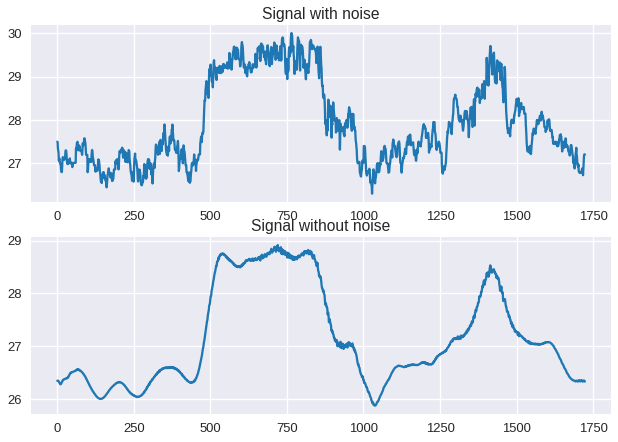

In [98]:
# Function to denoise the sensor data using wavelet transform
def wp_denoise(df):
    for column in df:
        x = df[column]
        wp = pywt.WaveletPacket(data=x, wavelet="db7")
        new_wp = pywt.WaveletPacket(data=None, wavelet="db7")
        
        for i in range(wp.maxlevel):
            nodes = [node.path for node in wp.get_level(i, "natural")]
            # Remove the high and low pass signals
            for node in nodes:
                sigma = mad(wp[node].data)
                uthresh = sigma * np.sqrt(2 * np.log(len(wp[node].data)))
                new_wp[node] = pywt.threshold(wp[node].data, value=uthresh, mode="soft")

        y = new_wp.reconstruct(update=False)[:len(x)]
        df[column] = y
    
    return df
    
# Denoise the sensor data
df_denoised = wp_denoise(df.iloc[:, 3:4])
df['Date'] = pd.to_datetime(df['Date'])

fig, (ax1, ax2) = plt.subplots(2, 1)

df['4030CFDC'].plot(ax=ax1, title="Signal with noise")
df_denoised['4030CFDC'].plot(ax=ax2, title="Signal without noise")

Summary
-------
> In this step, we have learned various common issues that can hinder model accuracy, such as not choosing the optimal probability cutoff point for class creation, variance, and bias. We also briefly looked at different model tuning techniques practiced, such as bagging, boosting, ensemble voting, and grid search/random search and Bayesian optimization techniques for hyperparameter tuning. We also looked at noise reduction technique for IoT data.